Task: Building model with deep learning

Deep Learning techniques can be used to predict various outcomes including but not limited to future sales. Your task is to create a deep learning model of the Long Short Term Memory which is a type of Recurrent Neural Network.

You can use either Tensorflow or Pytorch libraries for model building. The model should not be very deep (Two layers) due to the computational requirements, it should comfortably run in Google Colab.
Isolate the Rossmann Store Sales dataset into time series data     
Check whether your time Series Data is Stationary
Depending on your conclusion from 2 above differences your time series data
Check for autocorrelation and partial autocorrelation of your data
Transform the time series data into supervised learning data by creating a new y(target) column. For example, as illustrated here in the Sliding Window For Time Series Data section
Scale your data in the (-1, 1) range
Build an LSTM Regression model to predict the next sale.


To build an LSTM-based model for time series forecasting (predicting future sales) on the Rossmann Store Sales dataset, we need to go through several steps including data preparation, model building, and evaluation. Here's a detailed guide using TensorFlow and the steps we're looking for:

**Step-by-Step Implementation**

1. Import Required Libraries

In [97]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error



2. Load the Dataset



In [84]:
train_data = pd.read_csv('train_processed.csv', low_memory=False)
test_data = pd.read_csv('test_processed.csv', low_memory=False)

In [5]:
train_data.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'Promo2', 'Weekday', 'IsWeekend', 'Month', 'DaysToHoliday',
       'DaysAfterHoliday', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth',
       'IsHoliday', 'Promo_duration'],
      dtype='object')

In [6]:
train_data.head()

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Weekday,IsWeekend,Month,DaysToHoliday,DaysAfterHoliday,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,IsHoliday,Promo_duration
0,2015-07-31,1,5,5263.0,1.0,1.0,0.0,1.0,2.0,0.0,...,4.0,0.0,7.0,3069.0,-3069.0,0.0,0.0,1.0,1.0,1.0
1,2015-07-31,2,5,6064.0,1.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,7.0,3069.0,-3069.0,0.0,0.0,1.0,1.0,1.0
2,2015-07-31,3,5,8314.0,1.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,7.0,3069.0,-3069.0,0.0,0.0,1.0,1.0,1.0
3,2015-07-31,4,5,13995.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,0.0,7.0,3069.0,-3069.0,0.0,0.0,1.0,1.0,1.0
4,2015-07-31,5,5,4822.0,1.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,7.0,3069.0,-3069.0,0.0,0.0,1.0,1.0,1.0


In [7]:
test_data.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Weekday,IsWeekend,Month,DaysToHoliday,DaysAfterHoliday,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,IsHoliday,Promo_duration
0,1,1,4,1.0,1.0,0,0.0,2,0,1270.0,...,3,0,9,3021,-3021,0,1,0,0.0,1.0
1,2,3,4,1.0,1.0,0,0.0,0,0,14130.0,...,3,0,9,3021,-3021,0,1,0,0.0,1.0
2,3,7,4,1.0,1.0,0,0.0,0,2,15007.5,...,3,0,9,3021,-3021,0,1,0,0.0,1.0
3,4,8,4,1.0,1.0,0,0.0,0,0,7520.0,...,3,0,9,3021,-3021,0,1,0,0.0,1.0
4,5,9,4,1.0,1.0,0,0.0,0,2,2030.0,...,3,0,9,3021,-3021,0,1,0,0.0,1.0


**Step 3:** Isolate the Rossmann Store Sales Dataset for Time Series Analysis

First, we'll isolate the data for a single store, as LSTMs are typically used for time series analysis on a specific sequence.

In [86]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
data = train_data[['Date', 'Store', 'Sales']]

# Filter for a specific store (e.g., Store 1)
store_data = data[data['Store'] == 1]
store_data.set_index('Date', inplace=True)
store_data = store_data.resample('D').sum()  # Daily sales sum


**Step 4:** Check Whether the Time Series Data is Stationary
A stationary time series has constant mean and variance over time.

One way to check this is through the Augmented Dickey-Fuller (ADF) test.

In [87]:
# Check stationarity for a specific store
# Perform the ADF test
adf_result = adfuller(store_data['Sales'])

# Output the ADF statistic and p-value
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If p-value is < 0.05, the time series is stationary.
if adf_result[1] < 0.05:
    print("Time series is stationary")
else:
    print("Time series is not stationary")


ADF Statistic: -4.365979046843096
p-value: 0.0003408017066674904
Time series is stationary


**Step 4:** Difference the Time Series if Non-Stationary

If the time series is non-stationary (p-value > 0.05), we need to difference it to make it stationary.

Differencing helps by subtracting the previous value from the current value.

In [88]:
# Difference the series (store_data is a Series, no need to reference 'Sales')
if adf_result[1] >= 0.05:
    store_data['Sales'] = store_data['Sales'].diff().dropna()




**Step 6:** Autocorrelation and Partial Autocorrelation Analysis

The autocorrelation (ACF) and partial autocorrelation (PACF) help us understand the lag relationship in the data.

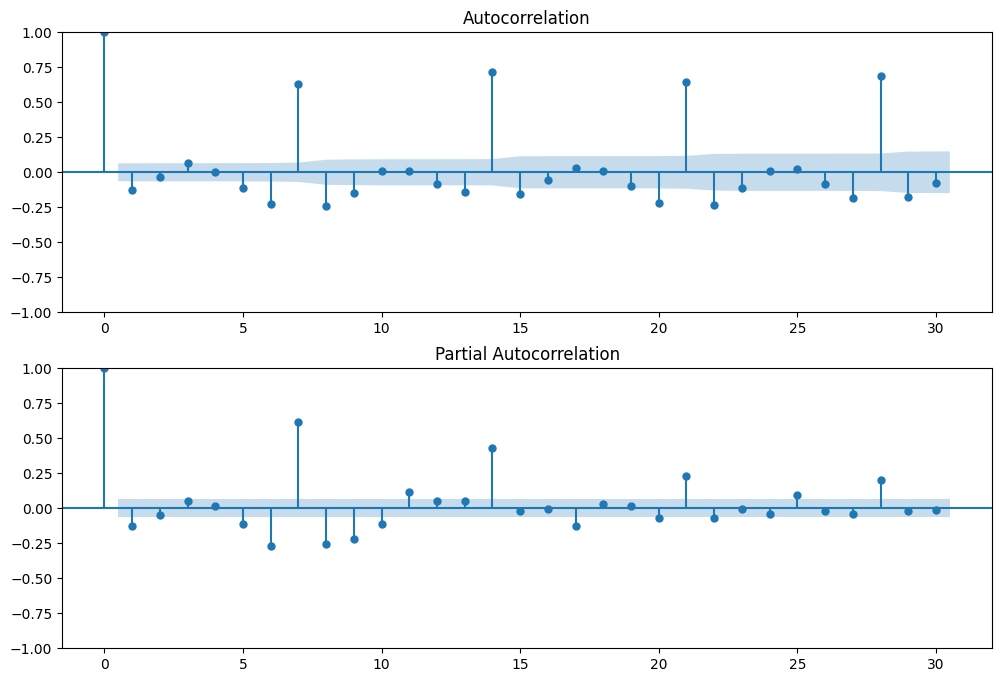

In [92]:
# Autocorrelation and Partial Autocorrelation plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(store_data['Sales'].dropna(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(store_data['Sales'].dropna(), lags=30, ax=ax[1])
plt.show()


**Step 7:** Transform Data into Supervised Learning (Sliding Window)

We need to transform the time series data into a supervised learning problem by creating sliding windows (or look-back windows).

In [93]:
# Create a function to convert time series data to supervised learning data
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time steps
time_step = 10
data_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(store_data['Sales'].values.reshape(-1, 1))
X, y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


**Step 8:** Scale the Data
LSTMs perform better when the data is scaled to a range like (-1, 1).

We can use the MinMaxScaler to achieve this.

In [104]:
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(store_data['Sales'].values.reshape(-1, 1))

# Create dataset for LSTM
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

**Step 9:** Build an LSTM Model

Now that the data is prepared, we can build a simple LSTM model using TensorFlow (Keras).

In [105]:
# Build LSTM Regression model
model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Define the input shape
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
# Fit the model and store the history
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1842 - val_loss: 0.1578
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1858 - val_loss: 0.1551
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1878 - val_loss: 0.1535
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1835 - val_loss: 0.1537
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1868 - val_loss: 0.1550
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1794 - val_loss: 0.1569
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2007 - val_loss: 0.1600
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1841 - val_loss: 0.1544
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1788 - val_loss: 0.1540
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1782 - val_loss: 0.1553
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1891 - val_loss: 0.1539
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1

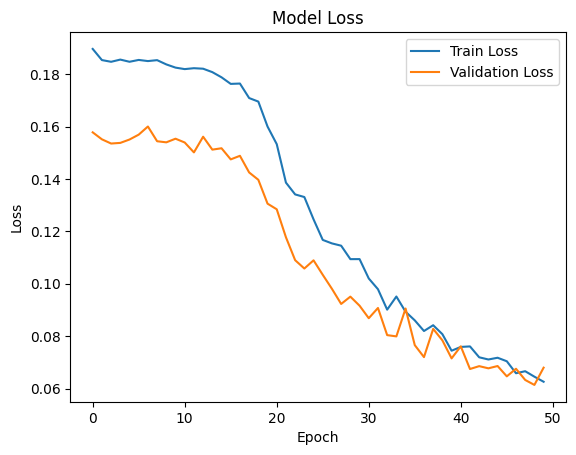

In [106]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


**Step 10:** Make Predictions
After training, we can predict future sales.

In [108]:
# Make predictions
predicted_sales = model.predict(X)

# Inverse transform to get actual sales values
predicted_sales = scaler.inverse_transform(predicted_sales.reshape(-1, 1))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


**Step 11:** Visualize the result

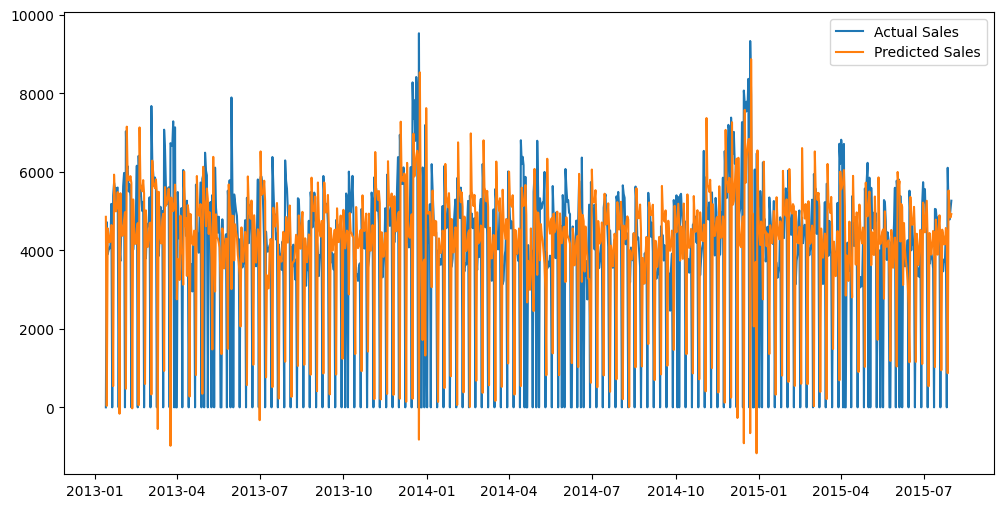

In [109]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(store_data.index[time_step+1:], store_data['Sales'][time_step+1:], label='Actual Sales')
plt.plot(store_data.index[time_step+1:], predicted_sales, label='Predicted Sales')
plt.legend()
plt.show()


**Step 12:** Evaluate the Model

We can evaluate the model using various metrics such as Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) or RMSLE.

In [110]:
# Calculate evaluation metrics
mae = mean_absolute_error(store_data['Sales'][time_step+1:], predicted_sales)
mse = mean_squared_error(store_data['Sales'][time_step+1:], predicted_sales)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')



Mean Absolute Error (MAE): 1810.1383102765647
Mean Squared Error (MSE): 6906563.057286556
Root Mean Squared Error (RMSE): 2628.0340669950524
